# Series de Tiempo
## Shampoo data set

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Preparación

In [58]:
#Obtención de los df
df = pd.read_csv('./shampoo.csv')

# Asumiendo que el primer año es 2001
start_year = 2001
# Convertimos "1-01" a "2001-01", "2-05" a "2002-05", etc.
df['ParsedMonth'] = df['Month'].apply(lambda x: f"{start_year + int(x.split('-')[0]) - 1}-{x.split('-')[1]}")

# Parseamos a datetime
df['ParsedMonth'] = pd.to_datetime(df['ParsedMonth'], format='%Y-%m')

# Separación de los df train/test
train_size = int(len(df) * 0.7)
train_data = df[0:train_size]
test_data = df[train_size:len(df)]

## Análisis exploratorio

In [40]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Reporte EDA", explorative=True)
profile.to_file("reporte.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 273.69it/s]


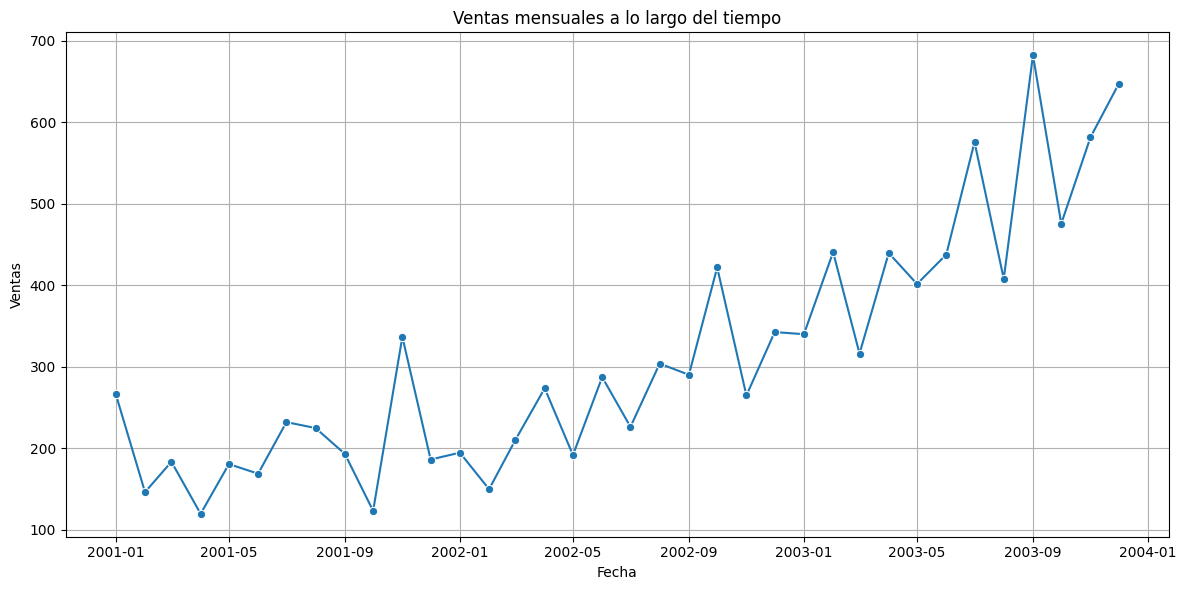

In [41]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='ParsedMonth', y='Sales', marker='o')
plt.title('Ventas mensuales a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.tight_layout()
plt.show()

Se observan ciclos anuales claros (patrón estacional).

Hay un aumento progresivo en las ventas con el tiempo lo que es indicio de una tendencia creciente.

Algunos picos muy pronunciados podrían indicar meses especiales o campañas.

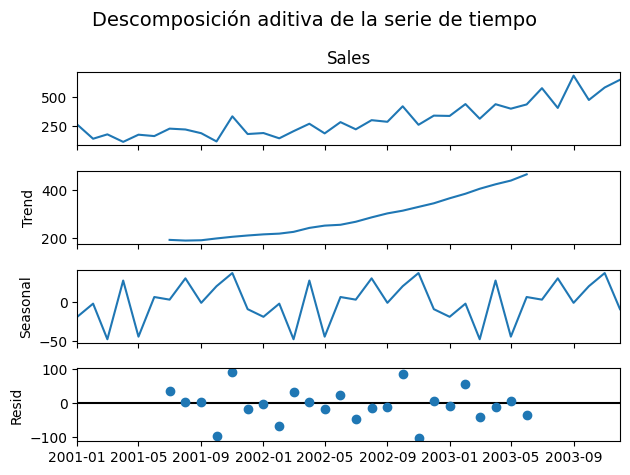

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Usar la columna con fecha como índice
df_ts = df.set_index('ParsedMonth')

# Descomposición aditiva
result = seasonal_decompose(df_ts['Sales'], model='additive', period=12)

# Graficar la descomposición
%matplotlib inline
result.plot()
plt.suptitle('Descomposición aditiva de la serie de tiempo', fontsize=14)
plt.tight_layout()
plt.show()

- Tendencia: Línea suave que muestra crecimiento continuo.
- Estacionalidad: Repetición de picos o valles según el mes.
- Ruido (residual): Variación aleatoria que no se explica por tendencia o estacionalidad.

## Algoritmos de Series de Tiempo

### Promedios Móviles

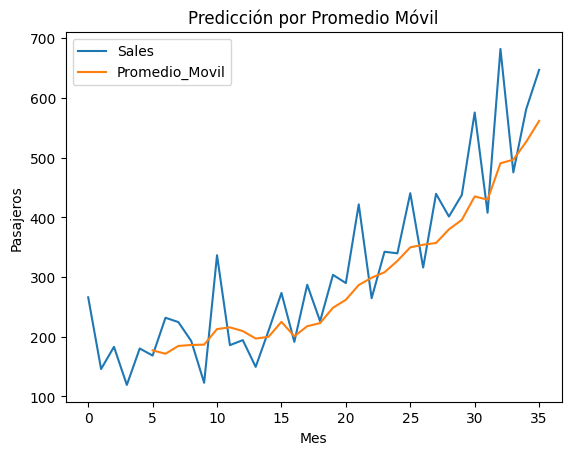

In [43]:
# Promedio Móvil
df['Promedio_Movil'] = df['Sales'].rolling(window = 6).mean()

# Graficar los df y el Promedio Móvil
df[['Sales', 'Promedio_Movil']].plot()
plt.title("Predicción por Promedio Móvil")
plt.xlabel("Mes")
plt.ylabel("Pasajeros")
plt.show()

El promedio móvil es un método puramente descriptivo y retrospectivo, no aprende patrones ni ajusta parámetros. Solo suaviza la serie calculando el promedio de los valores pasados en una ventana.
Por lo que, en general no tiene mucho sentido separar en train y test.

### Aislamiento exponencial

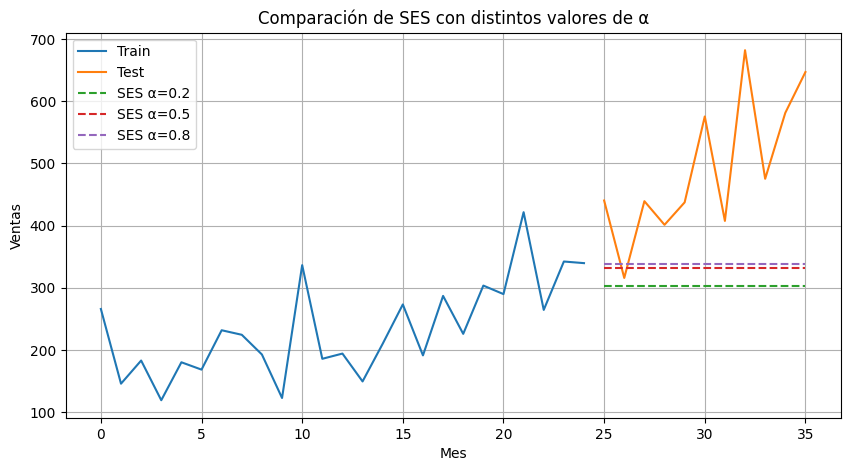

In [51]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Valores de alpha que queremos probar
alphas = [0.2, 0.5, 0.8]

# Crear la figura
plt.figure(figsize=(10, 5))

# Graficar los datos reales
plt.plot(train_data.index, train_data['Sales'], label='Train')
plt.plot(test_data.index, test_data['Sales'], label='Test')

# Entrenar un modelo para cada alpha y graficar la predicción
for alpha in alphas:
    modelo = SimpleExpSmoothing(train_data['Sales'])
    modelo_ajustado = modelo.fit(smoothing_level=alpha, optimized=False)
    predicciones = modelo_ajustado.forecast(len(test_data))
    plt.plot(test_data.index, predicciones, label=f'SES α={alpha}', linestyle='--')

# Personalización de la gráfica
plt.title('Comparación de SES con distintos valores de α')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

### HOLT-WINTERS

c:\Users\Fabi\Documents\U\GitHub\Lab1_SeriesDeTiempo\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Fabi\Documents\U\GitHub\Lab1_SeriesDeTiempo\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


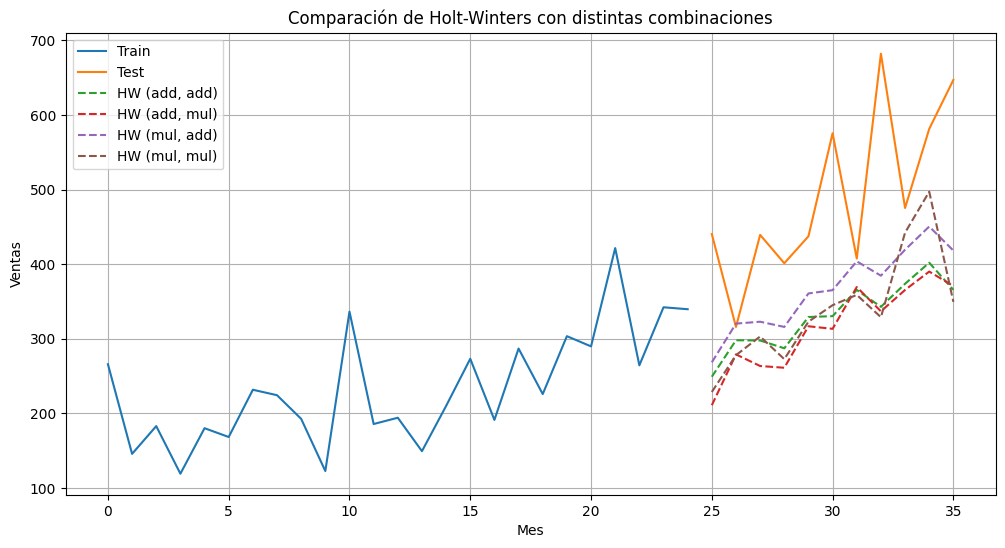

In [52]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Combinaciones que queremos probar
combinaciones = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar los datos reales
plt.plot(train_data.index, train_data['Sales'], label='Train')
plt.plot(test_data.index, test_data['Sales'], label='Test')

# Entrenar un modelo Holt-Winters para cada combinación
for trend, seasonal in combinaciones:
    modelo = ExponentialSmoothing(
        train_data['Sales'],
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=12
    )
    modelo_ajustado = modelo.fit()
    predicciones = modelo_ajustado.forecast(len(test_data))
    plt.plot(test_data.index, predicciones, label=f'HW ({trend}, {seasonal})', linestyle='--')

# Personalizar la gráfica
plt.title("Comparación de Holt-Winters con distintas combinaciones")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

### SARIMA

c:\Users\Fabi\Documents\U\GitHub\Lab1_SeriesDeTiempo\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Fabi\Documents\U\GitHub\Lab1_SeriesDeTiempo\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Fabi\Documents\U\GitHub\Lab1_SeriesDeTiempo\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Fabi\Documents\U\GitHub\Lab1_SeriesDeTiempo\.venv\Lib\site-packages\statsmod

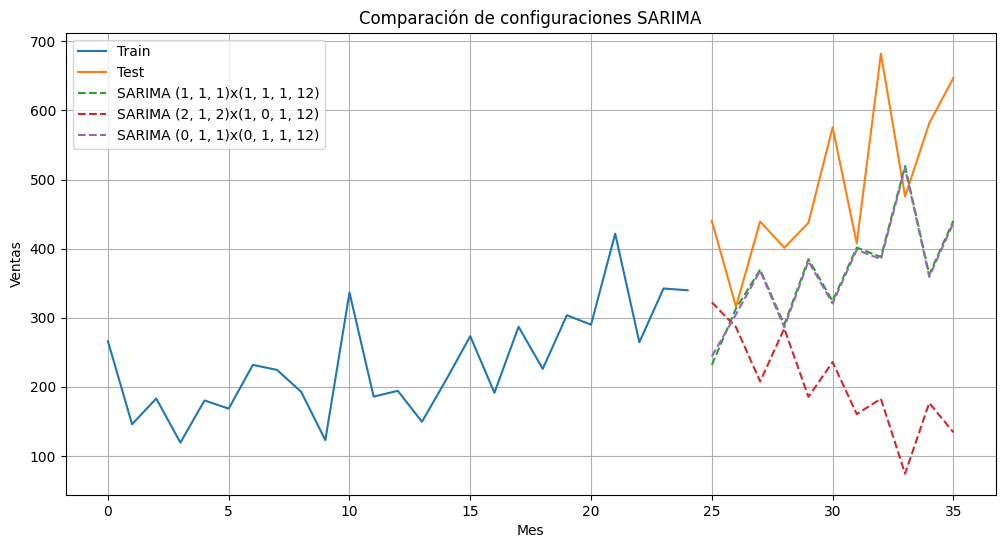

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Lista de configuraciones SARIMA a probar: ((p,d,q), (P,D,Q,s))
param_combinations = [
    ((1, 1, 1), (1, 1, 1, 12)),
    ((2, 1, 2), (1, 0, 1, 12)),
    ((0, 1, 1), (0, 1, 1, 12))
]

# Gráfico base con datos reales
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Sales'], label='Train')
plt.plot(test_data.index, test_data['Sales'], label='Test')

# Probar cada combinación
for i, (order, seasonal_order) in enumerate(param_combinations):
    modelo = SARIMAX(train_data['Sales'],
                     order=order,
                     seasonal_order=seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
    
    modelo_ajustado = modelo.fit(disp=False)
    predicciones = modelo_ajustado.get_forecast(steps=len(test_data)).predicted_mean
    
    label = f"SARIMA {order}x{seasonal_order}"
    plt.plot(test_data.index, predicciones, linestyle='--', label=label)

# Personalización del gráfico
plt.title("Comparación de configuraciones SARIMA")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

### Prophet

18:54:26 - cmdstanpy - INFO - Chain [1] start processing
18:54:26 - cmdstanpy - INFO - Chain [1] done processing
18:54:27 - cmdstanpy - INFO - Chain [1] start processing
18:54:27 - cmdstanpy - INFO - Chain [1] done processing
18:54:27 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing


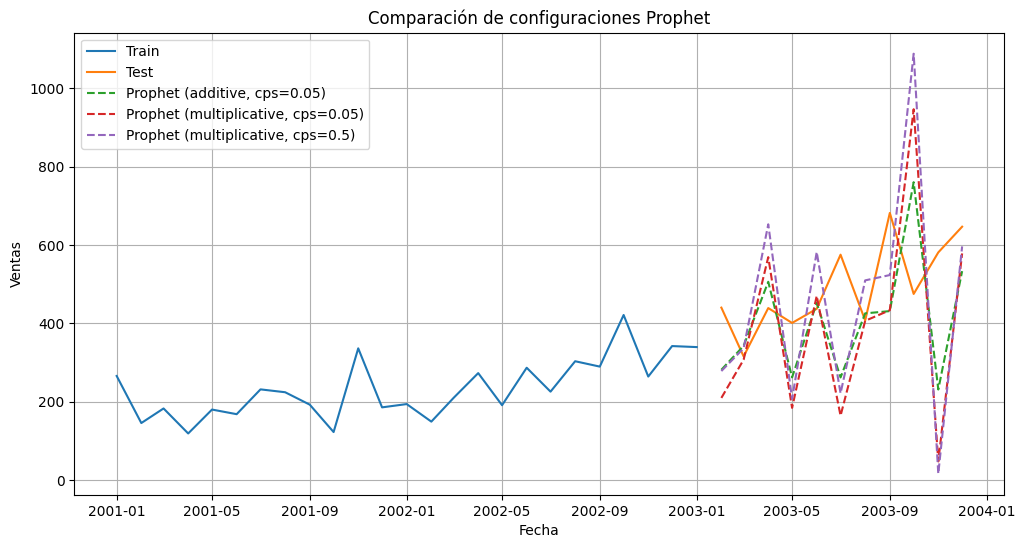

In [59]:
from prophet import Prophet

# Cargar y preparar los datos
df['ds'] = df['ParsedMonth']
df['y'] = df['Sales'].astype(float)
df = df[['ds', 'y']]

# Separar en train y test (ej. 70/30)
train_size = int(len(df) * 0.7)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Combinaciones a probar
configuraciones = [
    {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05},
    {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05},
    {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5}
]

# Graficar datos reales
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train')
plt.plot(test_df['ds'], test_df['y'], label='Test')

# Probar cada configuración
for config in configuraciones:
    modelo = Prophet(
        seasonality_mode=config['seasonality_mode'],
        changepoint_prior_scale=config['changepoint_prior_scale'],
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True
    )
    
    modelo.fit(train_df)
    futuro = modelo.make_future_dataframe(periods=len(test_df), freq='MS')
    predicciones = modelo.predict(futuro)
    pred_test = predicciones.iloc[-len(test_df):]
    
    label = f"Prophet ({config['seasonality_mode']}, cps={config['changepoint_prior_scale']})"
    plt.plot(pred_test['ds'], pred_test['yhat'], linestyle='--', label=label)

# Personalización del gráfico
plt.title("Comparación de configuraciones Prophet")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.show()

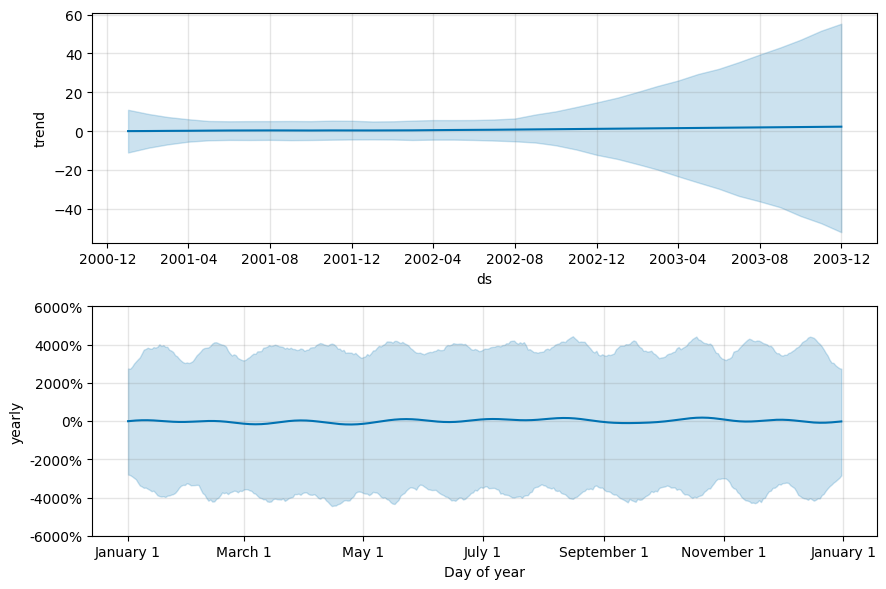

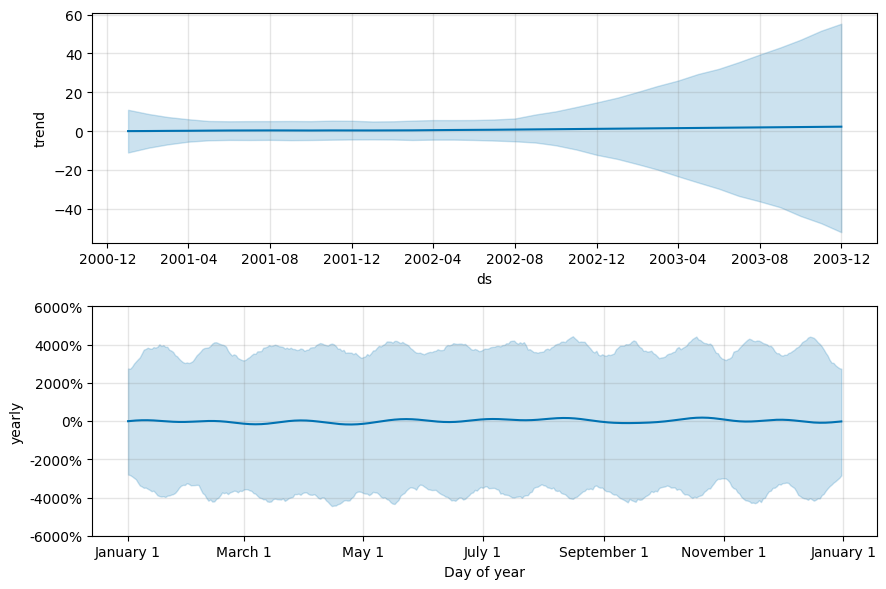

In [48]:
# Componentes de la serie
modelo.plot_components(predicciones)

## Comparación de algoritmos